In [8]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):  # e.g. for CIFAR-10
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),   # Removed padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Dynamically compute flatten size
        self._to_linear = None
        self._get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self._to_linear, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)  # Match your real input size
            out = self.features(dummy)
            self._to_linear = out.view(1, -1).shape[1]  # Flattened dimension

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Resize CIFAR images to 224x224
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# Step 2: CIFAR-10 loader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Step 3: Create model and update final layer
model = AlexNet(num_classes=10).to(device)

# Step 4: Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Step 5: Training loop
for epoch in range(5):  # adjust as needed
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print(f"[{epoch}, {i}] loss: {running_loss / (i + 1):.3f}")

print("Training done ✅")

[0, 0] loss: 2.303
[0, 100] loss: 2.303
[0, 200] loss: 2.301
[0, 300] loss: 2.270
[0, 400] loss: 2.213
[0, 500] loss: 2.156
[0, 600] loss: 2.101
[0, 700] loss: 2.044
[1, 0] loss: 1.567
[1, 100] loss: 1.533
[1, 200] loss: 1.517
[1, 300] loss: 1.499
[1, 400] loss: 1.463
[1, 500] loss: 1.438
[1, 600] loss: 1.416
[1, 700] loss: 1.392
[2, 0] loss: 1.234
[2, 100] loss: 1.111
[2, 200] loss: 1.111
[2, 300] loss: 1.091
[2, 400] loss: 1.086
[2, 500] loss: 1.067
[2, 600] loss: 1.054
[2, 700] loss: 1.045
[3, 0] loss: 1.054
[3, 100] loss: 0.864
[3, 200] loss: 0.864
[3, 300] loss: 0.860
[3, 400] loss: 0.857
[3, 500] loss: 0.859
[3, 600] loss: 0.856
[3, 700] loss: 0.849
[4, 0] loss: 0.647
[4, 100] loss: 0.734
[4, 200] loss: 0.734
[4, 300] loss: 0.722
[4, 400] loss: 0.722
[4, 500] loss: 0.723
[4, 600] loss: 0.717
[4, 700] loss: 0.714
Training done ✅


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

def visualize_filters(model, layer_name='features.0'):
    """
    Visualize filters from a specified layer of the model.
    Default: AlexNet's first conv layer.
    """
    # Get the layer
    conv_layer = dict(model.named_modules())[layer_name]
    
    # Extract weights
    filters = conv_layer.weight.data.clone().cpu()
    print(f"Filter shape: {filters.shape}")  # [out_channels, in_channels, H, W]

    # Normalize filters to [0, 1]
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # Make a grid of filters
    filter_grid = vutils.make_grid(filters, nrow=8, padding=1, normalize=False)

    # Convert to numpy and plot
    npimg = filter_grid.numpy().transpose((1, 2, 0))  # CHW -> HWC
    plt.figure(figsize=(10, 10))
    plt.title(f"Filters from layer: {layer_name}")
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()


Filter shape: torch.Size([96, 3, 11, 11])


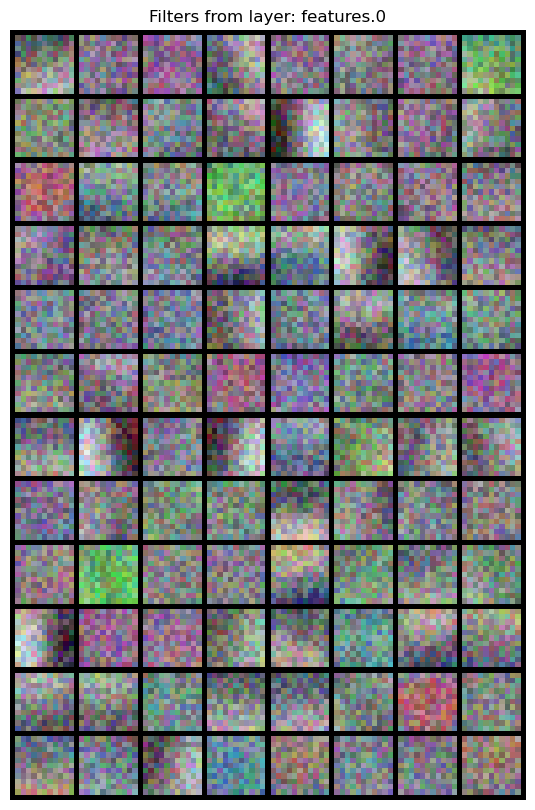

In [11]:
visualize_filters(model)